Feature Importance for 3D Soil Properties (static)
--------------------------------------------------

This notebook investigates feature importance scores and correlations for the soil property Organic Carbon (OC) at a given time (static model).

The model training data is based on soil data taken at sample sites in L'lara.  

Feature importances and ranks are calculated using a set of different models: 
- Spearman rank analysis (see 'selectio.models.spearman')
- Correlation coefficient significance of linear/log-scaled Bayesian Linear Regression (see 'selectio.models.blr')
- Random Forest Permutation test (see 'selectio.models.rf.py')
- Random Decision Trees on various subsamples of data (see 'selectio.models.rdt.py')
- Mutual Information Regression (see 'selectio.models.mi')
- General correlation coefficients (see 'selectio.models.xicor')


### Notebook Outline

The notebook will show feature importances for three scenarios:

1) OC feature importance for all depths
1) Only for top soil data 
3) Include depth as covariate feature

The main settings for reading and selecting data are defined in a settings yaml file ('settings_featureimportance_static.yaml').

This package is part of the machine learning project developed for the Agricultural Research Federation (AgReFed).



## Library imports

In [1]:
# Import libraries
import os 
import sys
import yaml
import shutil
from types import SimpleNamespace  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from selectio import selectio

# Import custom modules 
sys.path.append('../python_scripts')
from preprocessing import gen_kfold
import soilmod_predict as soilmod
import soilmod_xval as xval

 ### Settings file

 All settings related to datasets are specified in the .yaml file to make analysis reproducible.

In [2]:
# Define name of settings file to save configuration
fname_settings = 'settings_featureimportance_static.yaml'
path_settings = 'settings'

### Read and process feature importance settings

In [3]:
# Load settings from yaml file
with open(os.path.join(path_settings,fname_settings), 'r') as f:
    settings = yaml.load(f, Loader=yaml.FullLoader)
# Parse settings dictionary as namespace (settings are available as 
# settings.variable_name rather than settings['variable_name'])
settings = SimpleNamespace(**settings)

# Verify output directory and make it if it does not exist
os.makedirs(settings.outpath, exist_ok = True)

print("Main Settings:")
print("----------------")
for key in settings.__dict__:
    if key != "name_features":
        print(f"settings.{key} : {settings.__dict__[key]}")

# Print features selected
print("")
print("Available Features:")
print("----------------")
for key in settings.__dict__:
    if key == "name_features":
        for feature in settings.name_features:
            print(f"'{feature}'")

Main Settings:
----------------
settings.inpath : ../../../data/Llara/
settings.infname : soildata_depth.csv
settings.outpath : ../../../results/Llara/featureimportance_static/
settings.name_target : OC_WB
settings.colname_xcoord : Easting
settings.colname_ycoord : Northing
settings.colname_zcoord : mid_depth

Available Features:
----------------
'DEM_30'
'MrVBF'
'MrRTF'
'SlopeDeg'
'rad_dose'
'rad_u'
'rad_th'
'rad_k'
'silica'
'NDVI_5'
'NDVI_50'
'NDVI_95'
'rain'
'temp'
'TWI'
'Aspect'
'EM'
'gamma_K'


### Read in data

Coordinate origin (projected crs): 771206.3, 6646153.7


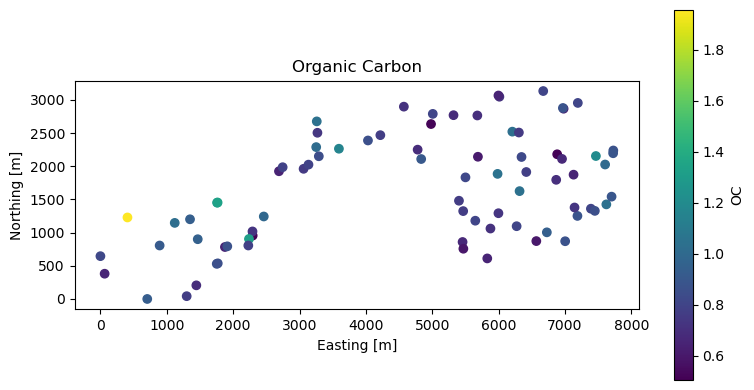

In [4]:
# read in data
df = pd.read_csv(os.path.join(settings.inpath,settings.infname))

# Map data distribution
xmin = df[settings.colname_xcoord].min()
ymin = df[settings.colname_ycoord].min()
print(f'Coordinate origin (projected crs): {xmin:.1f}, {ymin:.1f}')

# Scatter plot of OC as function of x and y position and only for top soil
dftop = df[df[settings.colname_zcoord] < 5]
fig, ax = plt.subplots(1, figsize = (8,4))
ax.scatter(dftop[settings.colname_xcoord] - xmin, dftop[settings.colname_ycoord]- ymin, c = dftop[settings.name_target], cmap = 'viridis')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Organic Carbon')
# set axis equal
ax.set_aspect('equal')
fig.colorbar(ax.collections[0], ax = ax, label = 'OC')
plt.tight_layout()
plt.show()

### Info about features

In [5]:
data_fieldnames = [settings.name_target, settings.colname_zcoord] + settings.name_features
dfsel = df[data_fieldnames]

# Verify that data is cleaned for tearget and feature variables:
assert dfsel.select_dtypes(include=['number']).columns.tolist().sort() == data_fieldnames.sort(), 'Data contains non-numeric entries.'
assert dfsel.isnull().sum().sum() == 0, "Data is not cleaned, please run preprocess_data.py before"

# Print data information
print("")
print("Data Information for 3D soil data:")
print("----------------")
print(f"Number of Features: {len(settings.name_features)}")
print(f"Number of Data points: {len(dfsel)}")

# Print data information for top soil data only

dfsel_top = dfsel[dfsel[settings.colname_zcoord] < 5]
print("")
print("Data Information for top soil data:")
print("----------------")
print(f"Number of Features: {len(settings.name_features)}")
print(f"Number of Data points: {len(dfsel_top)}")



Data Information for 3D soil data:
----------------
Number of Features: 18
Number of Data points: 299

Data Information for top soil data:
----------------
Number of Features: 18
Number of Data points: 79


## 1) OC feature importance for all depths

In [6]:
# Extract data arrays for X and y from dataframe
X = dfsel[settings.name_features].values
y = dfsel[settings.name_target].values

### Generate Spearman correlation matrix for X

Calculate Spearman correlation matrix ...


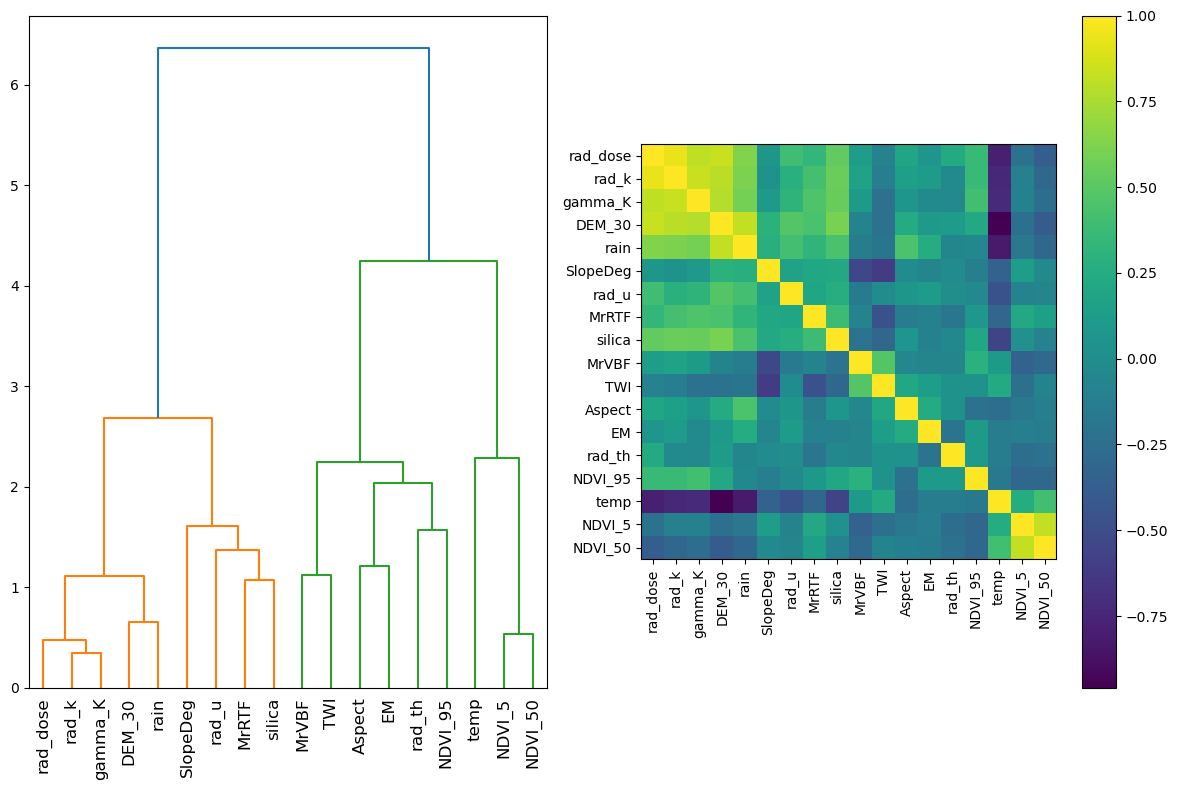

In [7]:
print("Calculate Spearman correlation matrix ...")
selectio.plot_feature_correlation_spearman(dfsel[settings.name_features].values, settings.name_features, settings.outpath, show = True)

The correlation matrix shows multiple feature-feature correlations such as in radiometric features (e.g., rad_dose vs rad_k) as well as anti-correlations (e.g., DEM-30 vs temp).

### Calculate Feature Importance Scores

In [8]:
fsel = selectio.Fsel(X, y)
dfresults = fsel.score_models()
# Add feature names
dfresults.insert(loc = 0, column = 'name_features', value = settings.name_features)
# Save results to csv
dfresults.to_csv(os.path.join(settings.outpath, 'results.csv'), index = False)
# Print results
dfresults

Computing scores for model spearman...
Done, 2 features selected.
Computing scores for model mi...
Done, 17 features selected.
Computing scores for model xicor...
Done, 15 features selected.
Computing scores for model blr...
Done, 1 features selected.
Computing scores for model rf...
Done, 11 features selected.
Computing scores for model rdt...
Done, 18 features selected.


,name_features,score_spearman,score_mi,score_xicor,score_blr,score_rf,score_rdt,woe_spearman,woe_mi,woe_xicor,woe_blr,woe_rf,woe_rdt,score_combined,selected
0,DEM_30,0.0000,0.0764,0.0734,0.0,0.0000,0.0391,0,1,1,0,0,1,0.0315,1
1,MrVBF,0.0000,0.0366,0.0000,0.0,0.0000,0.0203,0,1,0,0,0,1,0.0095,0
2,MrRTF,0.0000,0.0974,0.0382,0.0,0.0353,0.0613,0,1,1,0,1,1,0.0387,1
3,SlopeDeg,0.0000,0.0000,0.0731,0.0,0.1953,0.0680,0,0,1,0,1,1,0.0561,1
4,rad_dose,0.0000,0.0714,0.0615,0.0,0.0321,0.0338,0,1,1,0,1,1,0.0332,1
5,rad_u,0.0000,0.0974,0.0797,0.0,0.1690,0.0934,0,1,1,0,1,1,0.0733,1
6,rad_th,0.0000,0.0446,0.0673,0.0,0.0000,0.0374,0,1,1,0,0,1,0.0249,1
7,rad_k,0.0000,0.0513,0.0732,0.0,0.0000,0.0441,0,1,1,0,0,1,0.0281,1
8,silica,0.4526,0.0256,0.0000,0.0,0.0000,0.0637,1,1,0,0,0,1,0.0904,1
9,NDVI_5,0.0000,0.0624,0.0588,0.0,0.0532,0.0759,0,1,1,0,1,1,0.0417,1


### Generate feature importance plot for each model

Generating score plots ...


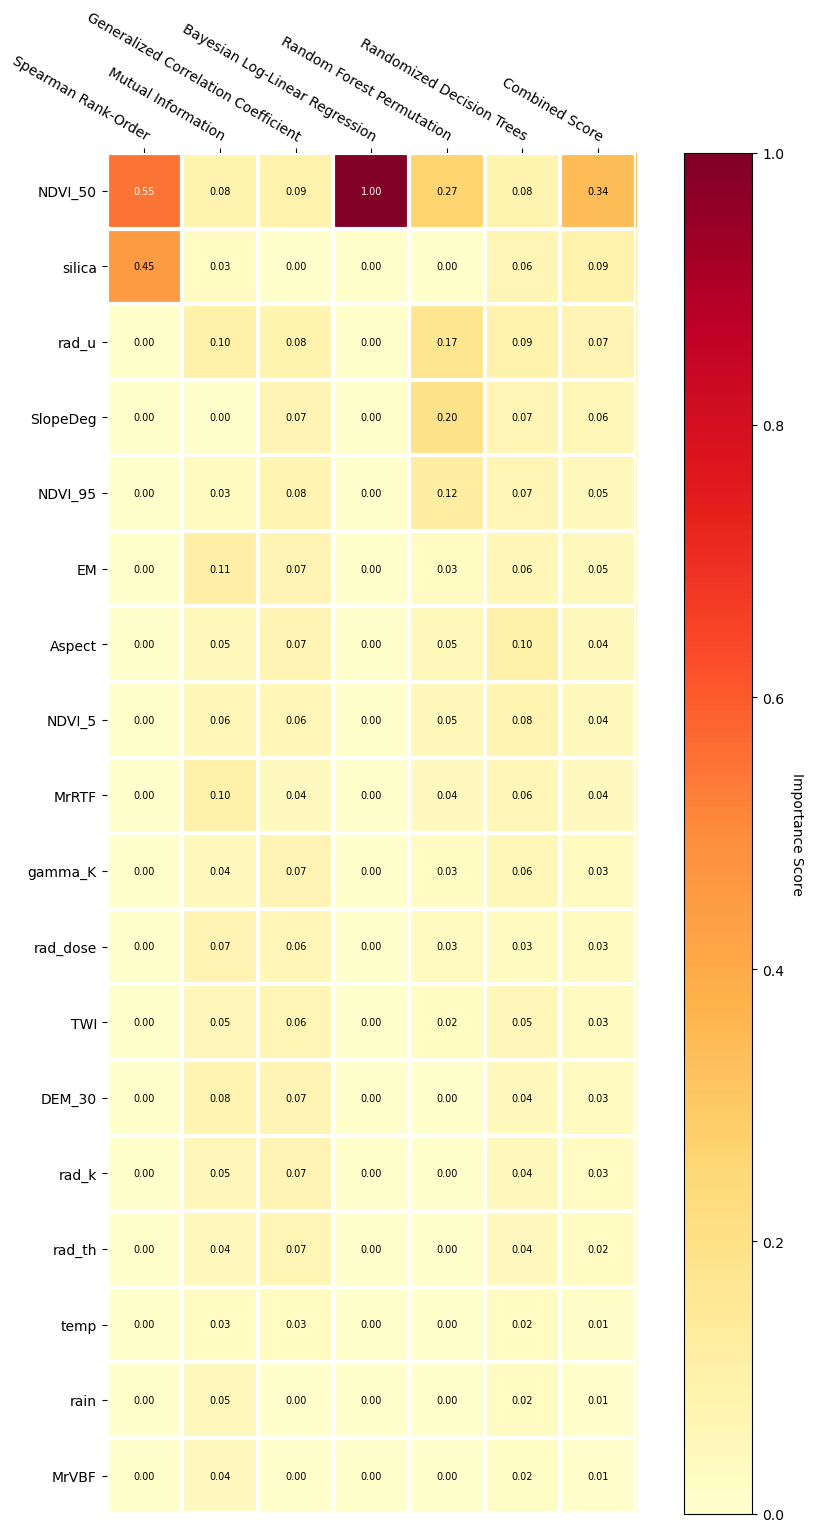

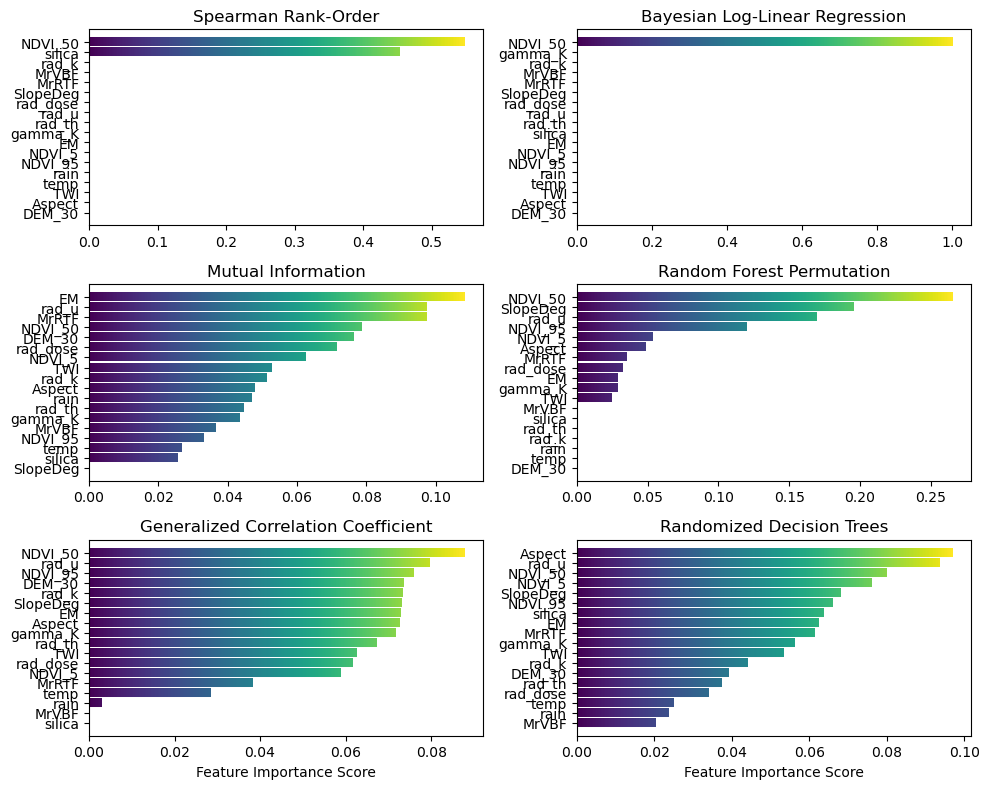

In [9]:
	# Plot scores
	print("Generating score plots ...")
	selectio.plot_allscores(dfresults, settings.outpath, show = True)

### Plot combined score

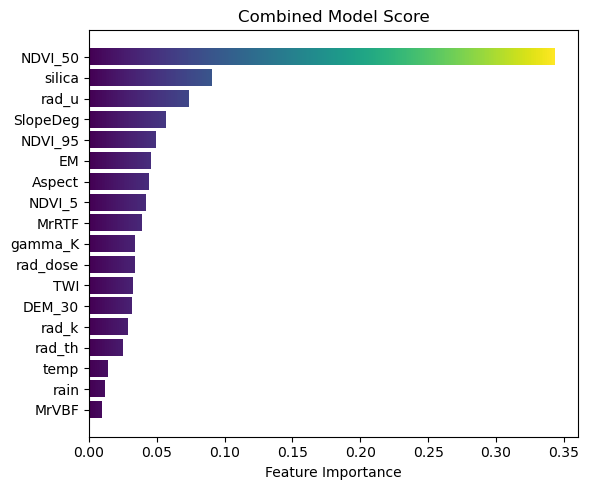

In [10]:
scores_total = dfresults['score_combined'].values
selectio.plot_correlationbar(
    scores_total, 
    settings.name_features, 
    settings.outpath, 
    'Combined-feature-importance.png', 
    name_method = 'Combined Model Score', 
    show = True)

## 2) Feature importance for top soil layer only

In [11]:
# Extract data arrays for X and y from dataframe
X = dfsel_top[settings.name_features].values
y = dfsel_top[settings.name_target].values

# Set additional output path for top soil only
settings.outpath += '_topsoil'
os.makedirs(settings.outpath, exist_ok = True)

### Generate Spearman correlation matrix for X

Calculate Spearman correlation matrix ...


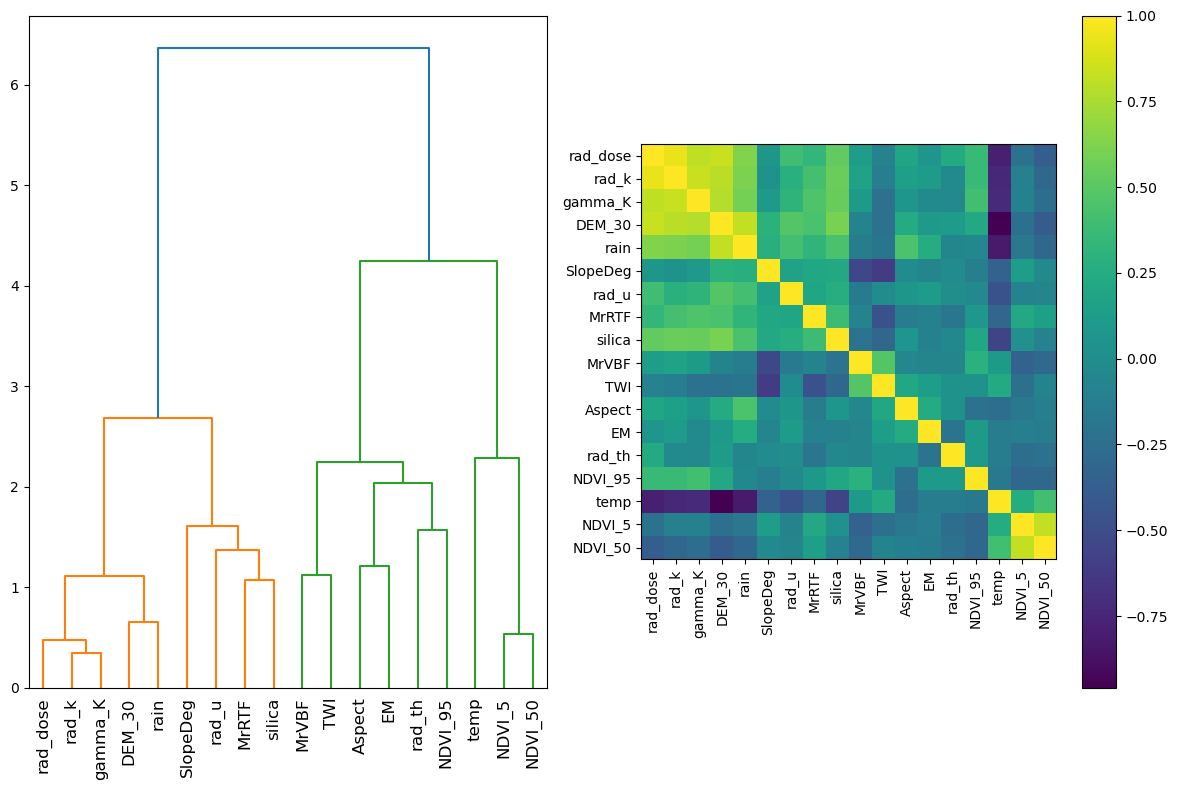

In [12]:
print("Calculate Spearman correlation matrix ...")
selectio.plot_feature_correlation_spearman(dfsel[settings.name_features].values, settings.name_features, settings.outpath, show = True)

The correlation matrix for top-soil shows similar feature-feature correlations as data with all depths.

### Calculate Feature Importance Scores

In [13]:
fsel = selectio.Fsel(X, y)
dfresults = fsel.score_models()
# Add feature names
dfresults.insert(loc = 0, column = 'name_features', value = settings.name_features)
# Save results to csv
dfresults.to_csv(os.path.join(settings.outpath, 'results.csv'), index = False)
# Print results
dfresults

Computing scores for model spearman...
Done, 1 features selected.
Computing scores for model mi...
Done, 11 features selected.
Computing scores for model xicor...
Done, 6 features selected.
Computing scores for model blr...
Done, 2 features selected.
Computing scores for model rf...
Done, 11 features selected.
Computing scores for model rdt...
Done, 18 features selected.


,name_features,score_spearman,score_mi,score_xicor,score_blr,score_rf,score_rdt,woe_spearman,woe_mi,woe_xicor,woe_blr,woe_rf,woe_rdt,score_combined,selected
0,DEM_30,0.0,0.0000,0.0000,0.0000,0.0674,0.0456,0,0,0,0,1,1,0.0191,0
1,MrVBF,0.0,0.0600,0.0547,0.0000,0.0000,0.0356,0,1,1,0,0,1,0.0253,1
2,MrRTF,0.0,0.0569,0.0000,0.0000,0.0227,0.0280,0,1,0,0,1,1,0.0181,1
3,SlopeDeg,0.0,0.0705,0.0000,0.0000,0.0796,0.0433,0,1,0,0,1,1,0.0326,1
4,rad_dose,0.0,0.1514,0.1086,0.0000,0.0263,0.0866,0,1,1,0,1,1,0.0628,1
5,rad_u,0.0,0.0980,0.0000,0.0000,0.1960,0.0846,0,1,0,0,1,1,0.0638,1
6,rad_th,0.0,0.0098,0.0000,0.0000,0.0153,0.0347,0,0,0,0,0,1,0.0058,0
7,rad_k,0.0,0.0950,0.1904,0.0000,0.0142,0.0370,0,1,1,0,0,1,0.0543,1
8,silica,0.0,0.0229,0.0000,0.0000,0.0000,0.1249,0,1,0,0,0,1,0.0249,0
9,NDVI_5,0.0,0.1457,0.0000,0.0000,0.0623,0.0575,0,1,0,0,1,1,0.0448,1


### Generate feature importance plot for each model

Generating score plots ...


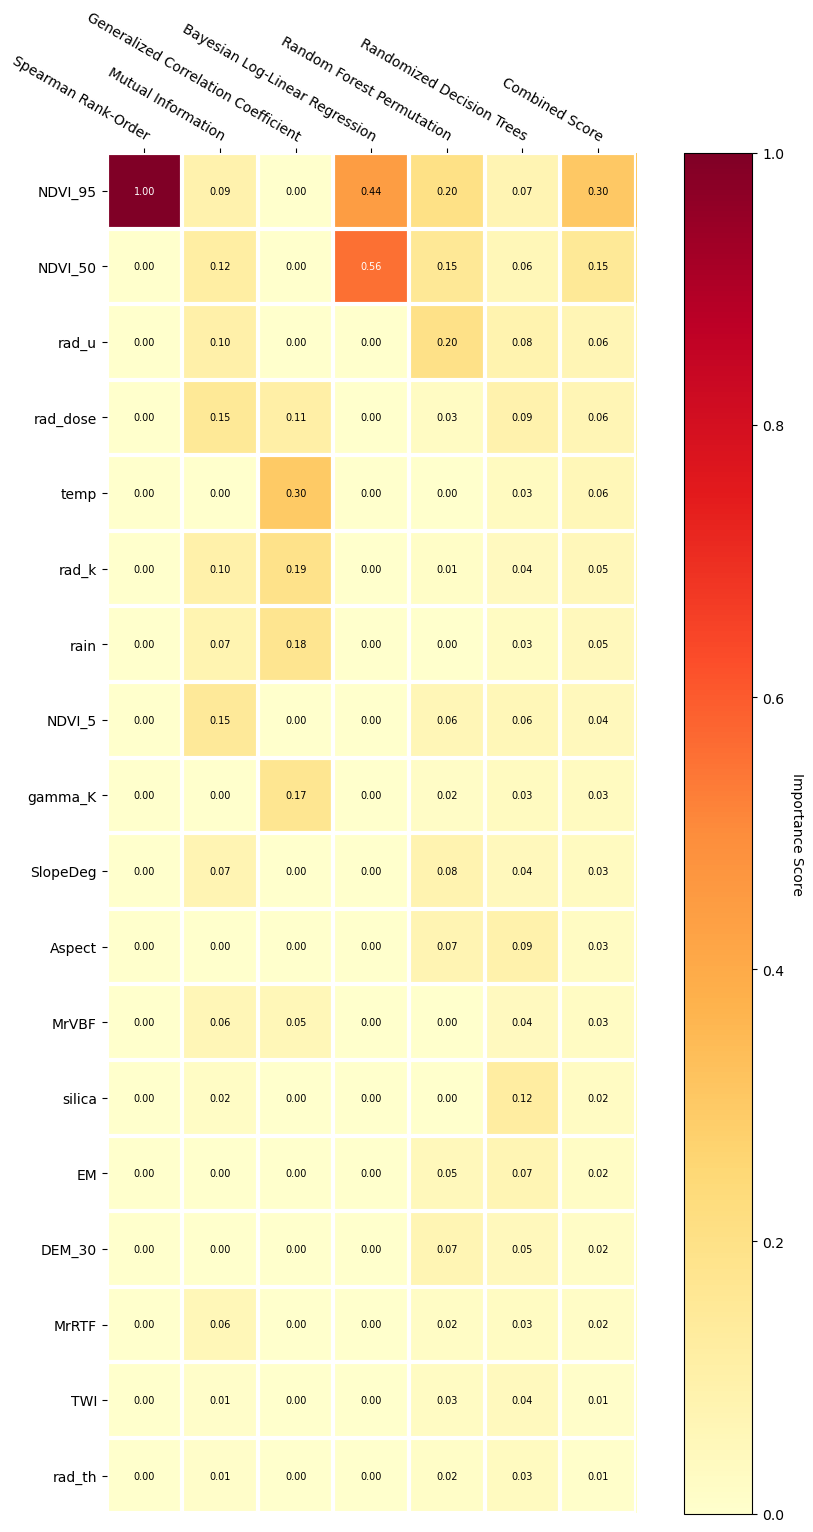

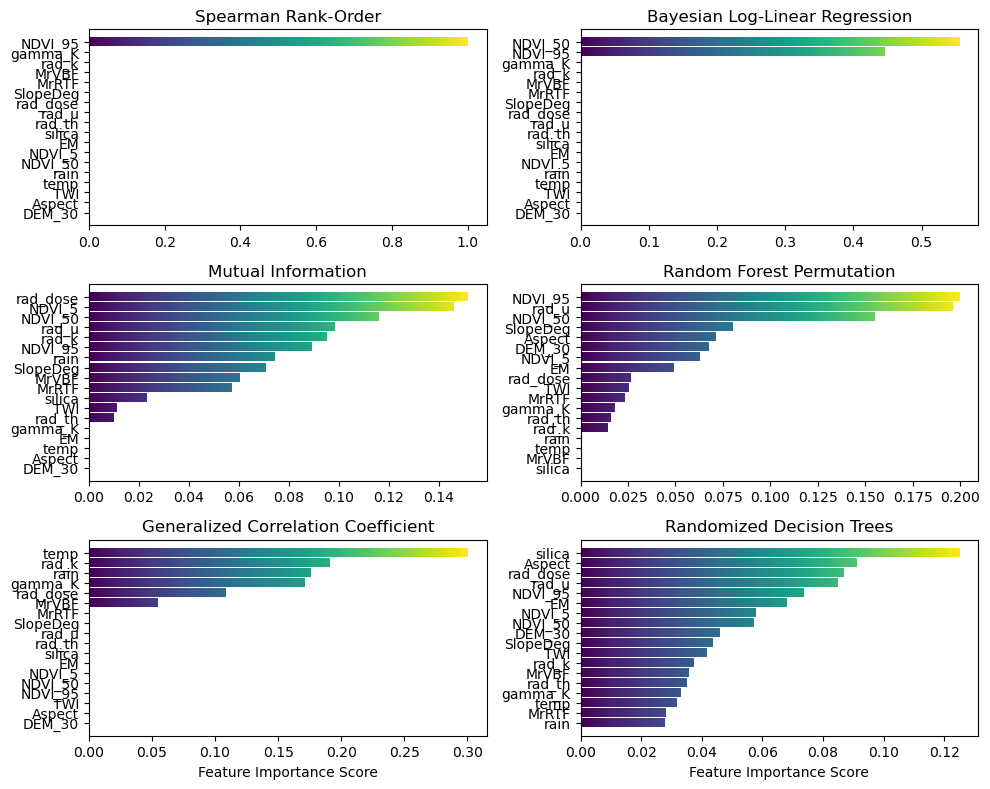

In [14]:
# Plot scores
print("Generating score plots ...")
selectio.plot_allscores(dfresults, settings.outpath, show = True)

### Plot combined score

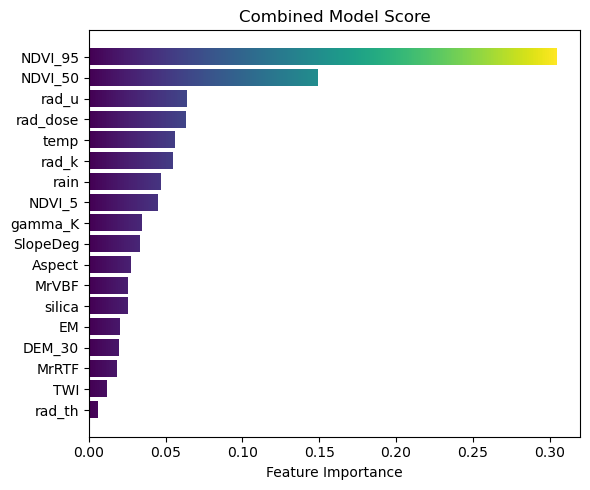

In [15]:
scores_total = dfresults['score_combined'].values
selectio.plot_correlationbar(
    scores_total, 
    settings.name_features, 
    settings.outpath, 
    'Combined-feature-importance.png', 
    name_method = 'Combined Model Score', 
    show = True)

## 3) Feature imoprtance if depth included as covariate feature

In [16]:
# Extract data arrays for X and y from dataframe
settings.name_features += [settings.colname_zcoord]
X = dfsel[settings.name_features].values
y = dfsel[settings.name_target].values

# Set additional output path for top soil only
settings.outpath += '_with_z'
os.makedirs(settings.outpath, exist_ok = True)

In [17]:
fsel = selectio.Fsel(X, y)
dfresults = fsel.score_models()
# Add feature names
dfresults.insert(loc = 0, column = 'name_features', value = settings.name_features)
# Save results to csv
dfresults.to_csv(os.path.join(settings.outpath, 'results.csv'), index = False)
# Print results
dfresults

Computing scores for model spearman...
Done, 3 features selected.
Computing scores for model mi...
Done, 18 features selected.
Computing scores for model xicor...
Done, 15 features selected.
Computing scores for model blr...
Done, 7 features selected.
Computing scores for model rf...
Done, 7 features selected.
Computing scores for model rdt...
Done, 15 features selected.


,name_features,score_spearman,score_mi,score_xicor,score_blr,score_rf,score_rdt,woe_spearman,woe_mi,woe_xicor,woe_blr,woe_rf,woe_rdt,score_combined,selected
0,DEM_30,0.0000,0.0651,0.0701,0.0000,0.0102,0.0224,0,1,1,0,0,1,0.0269,1
1,MrVBF,0.0000,0.0318,0.0000,0.0000,0.0000,0.0195,0,1,0,0,0,0,0.0054,0
2,MrRTF,0.0000,0.0818,0.0623,0.0000,0.0069,0.0219,0,1,1,0,0,1,0.0284,1
3,SlopeDeg,0.0000,0.0000,0.0635,0.0000,0.0320,0.0237,0,0,1,0,1,1,0.0204,1
4,rad_dose,0.0000,0.0592,0.0629,0.0000,0.0286,0.0371,0,1,1,0,1,1,0.0321,1
5,rad_u,0.0000,0.0809,0.0452,0.0000,0.0739,0.0537,0,1,1,0,1,1,0.0433,1
6,rad_th,0.0000,0.0375,0.0634,0.0000,0.0070,0.0192,0,1,1,0,0,0,0.0172,0
7,rad_k,0.0000,0.0435,0.0636,0.0000,0.0000,0.0238,0,1,1,0,0,1,0.0224,1
8,silica,0.1637,0.0293,0.0000,0.0564,0.0000,0.0556,1,1,0,1,0,1,0.0521,1
9,NDVI_5,0.0000,0.0488,0.0651,0.0653,0.0117,0.0318,0,1,1,1,0,1,0.0361,1


Generating score plots ...


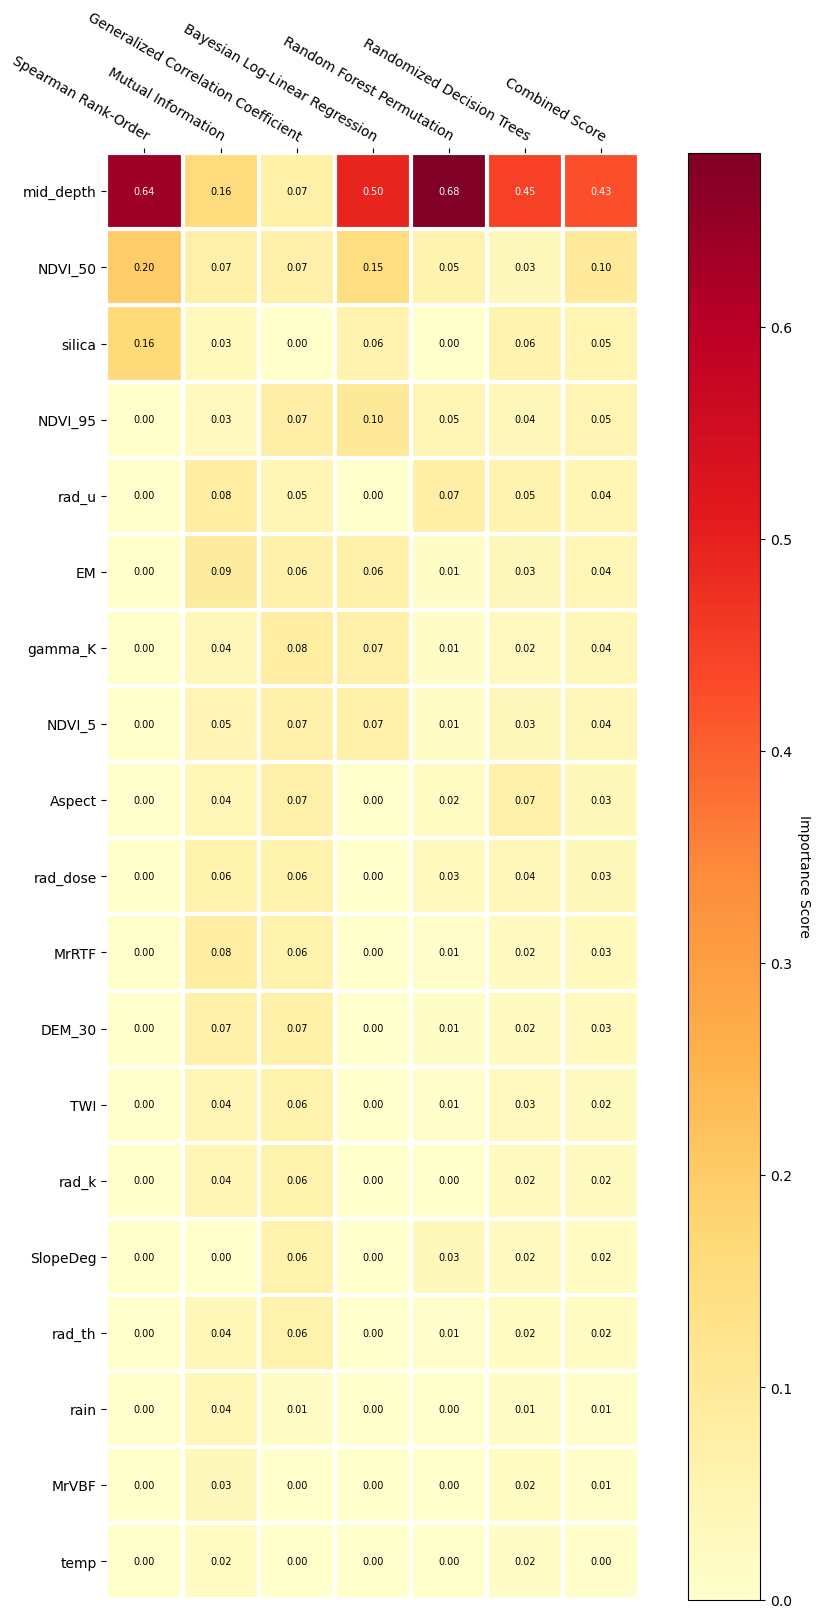

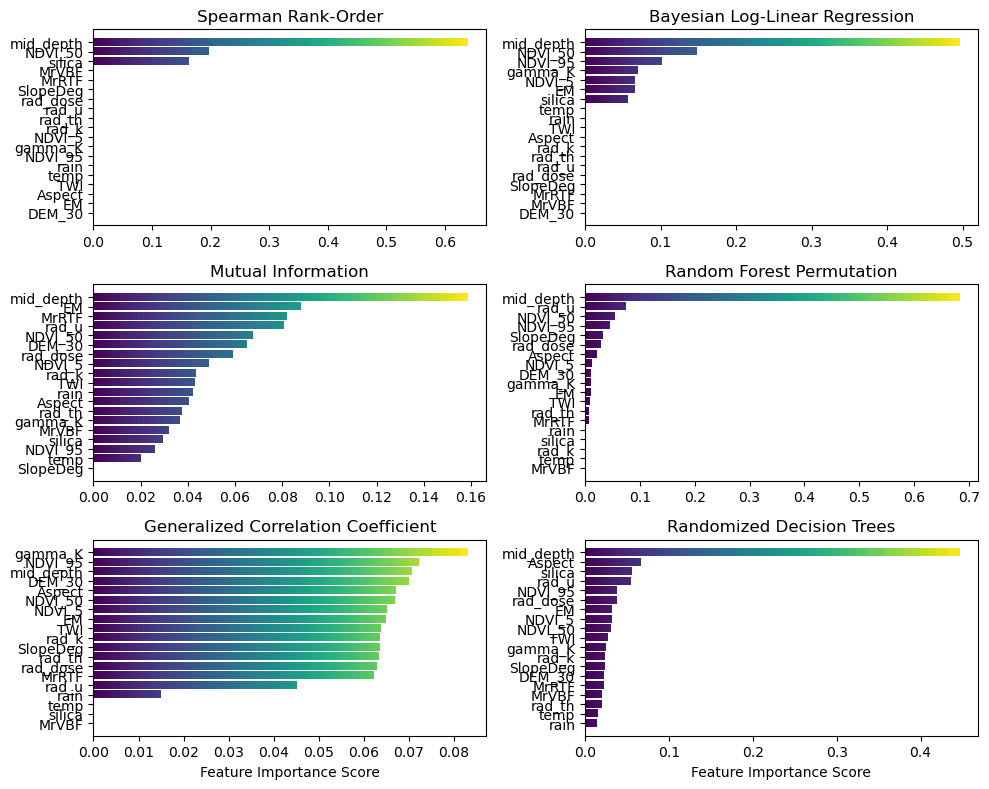

In [18]:
# Plot scores
print("Generating score plots ...")
selectio.plot_allscores(dfresults, settings.outpath, show = True)

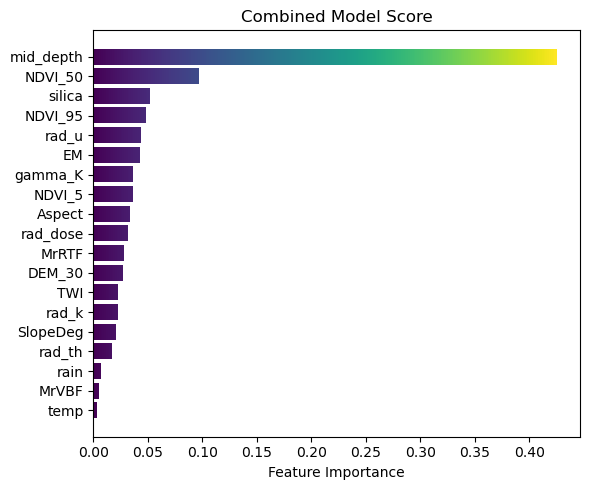

In [19]:
scores_total = dfresults['score_combined'].values
selectio.plot_correlationbar(
    scores_total, 
    settings.name_features, 
    settings.outpath, 
    'Combined-feature-importance.png', 
    name_method = 'Combined Model Score', 
    show = True)

### Conclusions from feature importance modeling for prediction target OC

- largest feature score for all soil data: NDVI-50, silica, rad_u
- largest feature score for top soil data only: NDVU-95, NDVI-50, rain
- if depth included as covariate feature, then depth is most important feature
- feature-to-feature correlations for radiometric data bewteen rad_dose, rad_k, and gamma_k
- feature-to-feature correlations for NDVI between NDVI-50 and NDVI-5
- Final feature selection: mid-depth, NDVI-50, NDVI-95, silica, rad_u, EM